<a href="https://colab.research.google.com/github/patricio-tech/proyectos/blob/master/BHcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Belo Horizonte
Redes neuronales convolucionales

Edwin Solís

2020

## RED NEURONAL DENSA

1. Carga de datos de 1 año **[Potencia Activa]**

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import keras.backend as K

In [ ]:

url = 'https://raw.githubusercontent.com/esoliss/AMI/master/Dataset/belohorizonte2017.csv'
df = pd.read_csv(url, error_bad_lines=False)
df = df.drop(columns=['Timestamp','kVARh rec int','kWh rec int','kVAR sd rec'])
df = df.drop(df.columns[-1],axis=1)
df = df.rename(columns={"kVAR sd del": "Q", "kVARh del int": "kVARh","kW sd del": "P","kWh del int": "kWh","kVA sd del": "S"})
df['Local Time'] = df['Local Time'].astype('datetime64[ns]')
var = list(df.columns)
va = {'Potencia Activa':var[3], 'Potencia Reactiva':var[1], 'Potencia Aparente': var[8], 'Voltaje An':var[5],
      'Voltaje Bn':var[6], 'Voltaje Cn':var[7], 'Corriente A':var[9], 'Corriente B':var[10], 'Corriente C':var[11],
      'Energía Activa':var[4], 'Energía Reactiva':var[3]}

# SELECCIONAR VARIABLE
select = 'Potencia Activa' 
## Opciones:
#'Potencia Activa', 'Potencia Reactiva', 'Potencia Aparente', 'Voltaje An', 'Voltaje bn', 'Voltaje Cn'
#'Corriente A', 'Corriente B', 'Corriente C', 'Energía Activa', 'Energía Reactiva'

dfil = df[['Local Time',va[select]]].copy()
n=0
for g in dfil[va[select]]:
    if g>2160:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']
    if g<500:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']-350
    n+=1
# SELECIONAR FECHAS
mes_inicio = 1
dia_inicio = 1
mes_final = 12
dia_final = 1

ini=datetime.datetime(2017,mes_inicio,dia_inicio,0,0)
if mes_inicio ==12:
    yf = 2018
else:
    yf =2017
fin=datetime.datetime(yf,mes_final,dia_final,0,0)
mask = (dfil["Local Time"]>=ini) & (dfil["Local Time"]<fin)
seq = dfil.loc[mask] 
dfil = seq

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2. Definición de funciones para el modelo

In [ ]:
# definición de métrica para precisión
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# creación del modelo
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    #model.add(Dense(1, activation='elu'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=[soft_acc])
    model.summary()
    return model
# Resultados
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test


3. Conversión de serie de tiempo

In [ ]:
PASOS=96
EPOCHS=100
# load dataset
values = dfil['P'].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled,PASOS,1)
# split into train and test sets
values = reframed.values
n_train_days = int(dfil.shape[0] - (dfil.shape[0]*0.2+PASOS))
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(25554, 1, 96) (25554,) (6413, 1, 96) (6413,)


4. Entrenamiento del modelo

In [ ]:

model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

results=model.predict(x_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 96)             9312      
_________________________________________________________________
flatten_1 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 97        
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
267/267 [==============================] - 1s 2ms/step - loss: 0.0699 - soft_acc: 0.9173 - val_loss: 0.0374 - val_soft_acc: 0.9637
Epoch 2/100
267/267 [==============================] - 0s 1ms/step - loss: 0.0380 - soft_acc: 0.9581 - val_loss: 0.0350 - val_soft_acc: 0.9712
Epoch 3/100
267/267 [==============================] - 0s 2ms/step - loss: 0.0319 - soft_acc: 0.

5. Comparativa y validación de datos

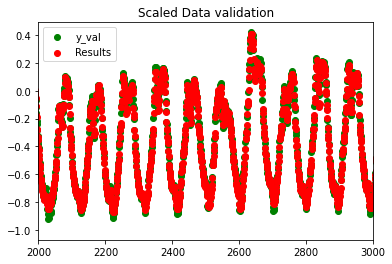

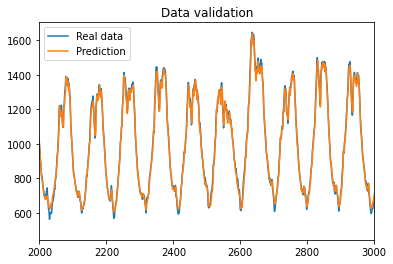

In [ ]:
plt.scatter(range(len(y_val)),y_val,c='g',label='y_val')
plt.scatter(range(len(results)),results,c='r',label='Results')
plt.title('Scaled Data validation')
if len(y_val)>2000:
  plt.xlim(2000, 3000)
plt.legend()
plt.show()

acc      = history.history[     'soft_acc' ]
val_acc  = history.history[ 'val_soft_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']

compara2['real'].plot(label='Real data' )
compara2['prediccion'].plot(label='Prediction' )
plt.title('Data validation')
if len(y_val)>2000:
  plt.xlim(2000, 3000)
plt.legend()
plt.show()

6. Métricas del modelo

<Figure size 432x288 with 0 Axes>

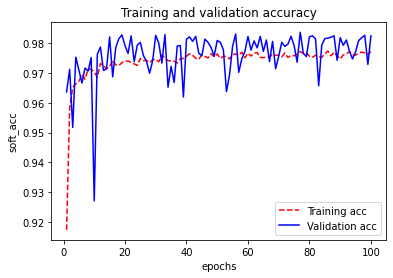

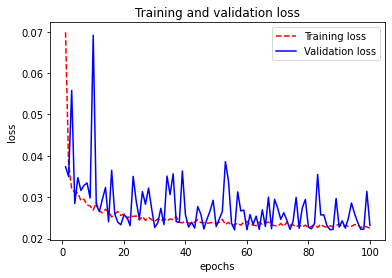

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('soft_acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--', label='Training loss' )
plt.plot ( epochs, val_loss ,  'b', label='Validation loss' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

7. Predicción de un día completo **[Febrero]**

In [ ]:
# SELECIONAR FECHAS
mes_inicio = 1
dia_inicio = 30
mes_final = 2
dia_final = 1
dfil = df[['Local Time',va[select]]].copy()
n=0
for g in dfil[va[select]]:
    if g>2160:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']
    if g<500:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']-350
    n+=1
ini=datetime.datetime(2017,mes_inicio,dia_inicio,0,0)
if mes_inicio ==12:
    yf = 2018
else:
    yf =2017
fin=datetime.datetime(yf,mes_final,dia_final,0,0)
mask = (dfil["Local Time"]>=ini) & (dfil["Local Time"]<fin)
seq = dfil.loc[mask] 
dfd = seq
values = dfd['P'].values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[96]], axis=1, inplace=True)
values = reframed.values
x_test = values[95:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(1, 1, 96)


In [ ]:
results=[]
for i in range(96):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    #print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

# SELECIONAR FECHAS
mes_inicio = 2
dia_inicio = 1
mes_final = 2
dia_final = 2

dfil = df[['Local Time',va[select]]].copy()
n=0
for g in dfil[va[select]]:
    if g>2160:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']
    if g<500:
        dfil[va[select]][n]=dfil.describe()[va[select]]['mean']-350
    n+=1
ini=datetime.datetime(2017,mes_inicio,dia_inicio,0,0)
if mes_inicio ==12:
    yf = 2018
else:
    yf =2017
fin=datetime.datetime(yf,mes_final,dia_final,0,0)
mask = (dfil["Local Time"]>=ini) & (dfil["Local Time"]<fin)
seq = dfil.loc[mask] 
dfd = seq
values = dfd['P'].values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1)
y_val = scaler.fit_transform(values)
compara = pd.DataFrame(np.array([y_val[:,0], [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']
inverted = scaler.inverse_transform(compara.values)
compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']


In [ ]:
compara2['real'].plot(label='Real data' )
compara2['prediccion'].plot(label='Prediction' )
plt.title('Prediccion Febrero')
plt.legend()
plt.show()